# Load Datasets

In [46]:
import pandas as pd
path = 'Data/nonpotential_cillabel'
result_path = 'Result/nonpotential_cillabel'
df_train = pd.read_csv(f'{path}/df_train.csv')
df_syn_ctgan = pd.read_csv(f'{path}/df_syn_ctgan.csv')
df_syn_ctabgan = pd.read_csv(f'{path}/df_syn_ctabgan.csv')
df_syn_tvae = pd.read_csv(f'{path}/df_syn_tvae.csv')
df_syn_ds = pd.read_csv(f'{path}/df_syn_ds.csv')
#df_syn_great = pd.read_csv(f'{path}/df_syn_great.csv')
df_syn_tabula = pd.read_csv(f'{path}/df_syn_tabula.csv')
df_syn_tabddpm = pd.read_csv(f'{path}/df_syn_tabddpm.csv')
df_holdout = pd.read_csv(f'{path}/df_holdout.csv')
df_val = pd.read_csv(f'{path}/df_val.csv')
print("data is loaded...")

data is loaded...


In [47]:
df_syn_tabula.loc[df_syn_tabula['cillabel'] > 1, 'cillabel'] = 1
df_syn_tabula.to_csv(f"{path}/df_syn_tabula.csv", index = True)

In [38]:
from Dataset_Utility import utility_functions as uf
uf.calculate_label_rate2(df_train, 'cillabel')
uf.calculate_label_rate2(df_syn_ctgan, 'cillabel')
uf.calculate_label_rate2(df_syn_ctabgan, 'cillabel')
uf.calculate_label_rate2(df_syn_tvae, 'cillabel')
uf.calculate_label_rate2(df_syn_ds, 'cillabel')
#uf.calculate_label_rate2(df_syn_great, 'cillabel')
uf.calculate_label_rate2(df_syn_tabula, 'cillabel')
uf.calculate_label_rate2(df_syn_tabddpm, 'cillabel')
uf.calculate_label_rate2(df_holdout, 'cillabel')
uf.calculate_label_rate2(df_val, 'cillabel')

Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.0002
Total Sample size is 19999, Positive Sample size is 201, Negative Sample size is 19798, label rate is 0.0102
Total Sample size is 19999, Positive Sample size is 290, Negative Sample size is 19709, label rate is 0.0147
Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.0002
Total Sample size is 19999, Positive Sample size is 12, Negative Sample size is 19987, label rate is 0.0006
Total Sample size is 19999, Positive Sample size is 2, Negative Sample size is 19997, label rate is 0.0001
Total Sample size is 19999, Positive Sample size is 1766, Negative Sample size is 18233, label rate is 0.0969
Total Sample size is 19999, Positive Sample size is 4, Negative Sample size is 19995, label rate is 0.0002
Total Sample size is 9999, Positive Sample size is 2, Negative Sample size is 9997, label rate is 0.0002


# 1. Train Classifier and Evaluate

In [39]:
#!pip install pygam
#!pip install xgboost
#!pip install git+https://github.com/lemeln/nam

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from pygam import LogisticGAM
from xgboost import XGBClassifier
from nam.wrapper import NAMClassifier

# Dictionary of models
models = {
    'LR': LogisticRegression(),
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'SVM': SVC(random_state=0, probability=True),
    'RF': RandomForestClassifier(random_state=0),    
    #'GAM': LogisticGAM(), # Does not converge
    'XGB': XGBClassifier()#,
    #'NAM': NAMClassifier()
}

# Dictionary of samples
samples = {
    'Training': df_train,
    'Holdout': df_holdout,
    'CTGAN': df_syn_ctgan,
    'CTABGAN': df_syn_ctabgan,
    'TVAE': df_syn_tvae,
    'DS': df_syn_ds,
    #'GReaT': df_syn_great,
    'Tabula': df_syn_tabula,
    'TabDDPM': df_syn_tabddpm
}

In [41]:
# Use the following loop, we can get sets of predictors and sets of response of each sample
# For example, X_CTGAN is the set of predictors for the df_syn_ctgan sample
for name, sample in samples.items():
    globals()[f'X_{name}'] = sample.drop('cillabel', axis=1) # Predictors
    globals()[f'y_{name}'] = sample['cillabel'] # Response

X_val = df_val.drop('cillabel', axis=1) # Predictors of valide
y_val = df_val['cillabel'] # Response of valid

In [42]:
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score,recall_score, precision_score

# Create a dataframe to save the result
sample_model = []
for sample in samples.keys():
    for model in models.keys():
        sample_model.append(f'{sample}_{model}')        
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
result = pd.DataFrame(index = sample_model, columns=columns)

def model_evaluation(name, model, sample, X_train, y_train, X_val, y_val):
    # Standardize training set and valid set 
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    # Fit model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    # Predict probabilities
    if ind == 1:
        y_proba = model.predict_proba(X_val) # When the model is GAM or NAM
    else:
        y_proba = model.predict_proba(X_val)[:,1] # Otherwise
    
    # Metric 1: accuracy
    accuracy = accuracy_score(y_val, y_pred)
    # Metric 2: ROC AUC
    auroc = roc_auc_score(y_val, y_proba)
    # Metric 3: F1 score
    f1 = f1_score(y_val, y_pred)
    # Metric 4: recall score
    recall = recall_score(y_val, y_pred) 
    # Metric 5: precision score
    precision = precision_score(y_val, y_pred)  
    # Metric 6: average_precision    
    ap = average_precision_score(y_val, y_proba)
    # Metric 7: confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    tpr = tp / (tp + fn)  
    fpr = fp / (fp + tn)  
    tnr = tn / (tn + fp)  
    fnr = fn / (tp + fn)
    
    result.loc[f'{sample}_{name}'] = [
        round(accuracy, 3), round(auroc, 3), round(f1, 3), round(recall, 3), round(precision, 3), round(ap, 3),
        round(tpr, 3), round(fpr, 3), round(tnr, 3), round(fnr, 3)
    ]
    
    # For figures
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    globals()[f'{sample}_{name}_fpr'] = fpr
    globals()[f'{sample}_{name}_tpr'] = tpr
    globals()[f'{sample}_{name}_auc'] = roc_auc
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)
    globals()[f'{sample}_{name}_precision'] = precision
    globals()[f'{sample}_{name}_recall'] = recall
    globals()[f'{sample}_{name}_ap'] = ap
    
    #print(sample + " "+ name +" done")

***There are warnings showing results have value 0 for some precisions.***

In [43]:
for sample in samples.keys():
    X_train = globals()[f'X_{sample}']
    y_train = globals()[f'y_{sample}']
    for name, model in models.items():
        if name == "GAM" or name == "NAM":
            ind = 1
        else:
            ind = 0
        model_evaluation(name, model, sample, X_train, y_train, X_val, y_val)

result.to_csv(f"{path}/result.csv", index = True)
result.to_csv(f"{result_path}/result.csv", index = True)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# 2. Evaluation Result

In [44]:
# Ordered by sample names
result

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR
Training_LR,1.0,0.96,0.0,0.0,0.0,0.004,0.0,0.0,1.0,1.0
Training_DT,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Training_KNN,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Training_NB,0.837,0.85,0.001,0.5,0.001,0.009,0.5,0.163,0.837,0.5
Training_SVM,1.0,0.91,0.0,0.0,0.0,0.002,0.0,0.0,1.0,1.0
Training_RF,1.0,0.495,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
Training_XGB,1.0,0.666,0.0,0.0,0.0,0.003,0.0,0.0,1.0,1.0
Holdout_LR,1.0,0.982,0.0,0.0,0.0,0.008,0.0,0.0,1.0,1.0
Holdout_DT,0.999,0.5,0.0,0.0,0.0,0.0,0.0,0.001,0.999,1.0
Holdout_KNN,1.0,0.499,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [48]:
# Result 2 only has a different order of index from above result
# Ordered by model names

model_sample = []
for model in models.keys():
    for sample in samples.keys():
        model_sample.append(f'{model}_{sample}')
        
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
result2 = pd.DataFrame(index = model_sample, columns=columns)

for name, model in models.items():
    for sample in samples.keys():
        result2.loc[f'{name}_{sample}'] = result.loc[f'{sample}_{name}']
        
result2

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR
LR_Training,1.0,0.96,0.0,0.0,0.0,0.004,0.0,0.0,1.0,1.0
LR_Holdout,1.0,0.982,0.0,0.0,0.0,0.008,0.0,0.0,1.0,1.0
LR_CTGAN,0.996,0.992,0.054,0.5,0.029,0.036,0.5,0.003,0.997,0.5
LR_CTABGAN,1.0,0.977,0.0,0.0,0.0,0.03,0.0,0.0,1.0,1.0
LR_TVAE,1.0,0.964,0.0,0.0,0.0,0.004,0.0,0.0,1.0,1.0
LR_DS,1.0,0.9,0.0,0.0,0.0,0.007,0.0,0.0,1.0,1.0
LR_Tabula,1.0,0.806,0.0,0.0,0.0,0.002,0.0,0.0,1.0,1.0
LR_TabDDPM,1.0,0.939,0.0,0.0,0.0,0.004,0.0,0.0,1.0,1.0
DT_Training,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
DT_Holdout,0.999,0.5,0.0,0.0,0.0,0.0,0.0,0.001,0.999,1.0


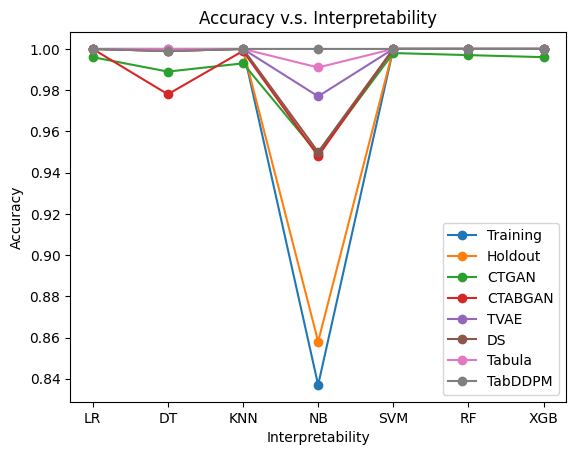

In [49]:
import matplotlib.pyplot as plt

# Plot of Accuracy
for sample in samples.keys():
    accuracy = []
    for model in models.keys():
        accuracy.append(result.loc[f'{sample}_{model}']["Accuracy"])
    plt.plot(models.keys(), accuracy , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.title('Accuracy v.s. Interpretability')
plt.show()

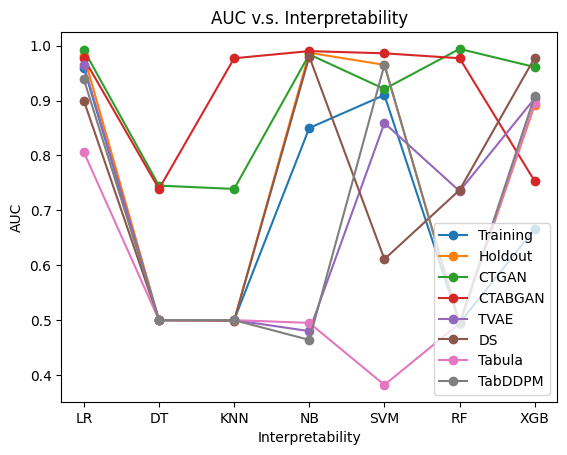

In [50]:
# Plot of AUC

for sample in samples.keys():
    auc = []
    for model in models.keys():
        auc.append(result.loc[f'{sample}_{model}']["AUC"])
    plt.plot(models.keys(), auc , 'o-', label=f'{sample}')
plt.xlabel('Interpretability')
plt.ylabel('AUC')
plt.legend(loc="lower right")
plt.title('AUC v.s. Interpretability')
plt.show()

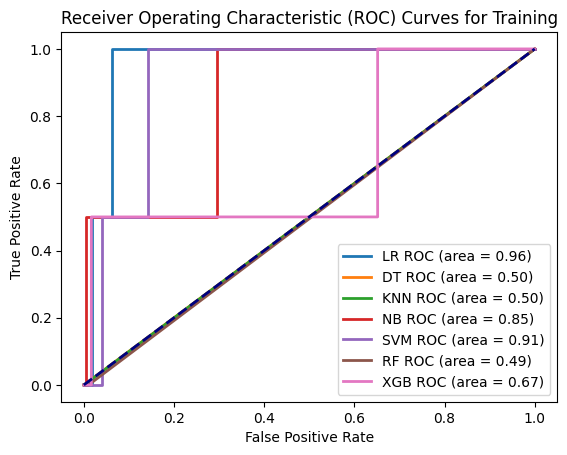

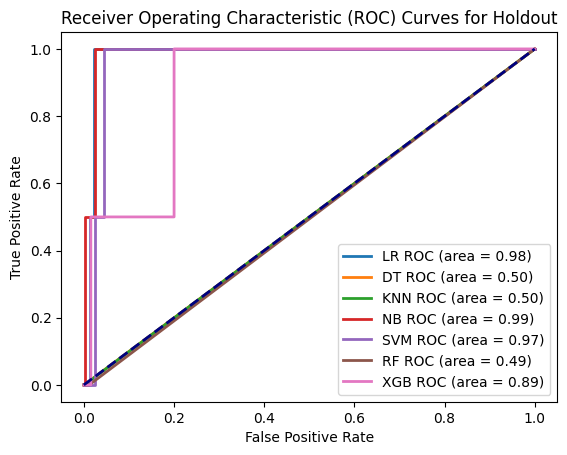

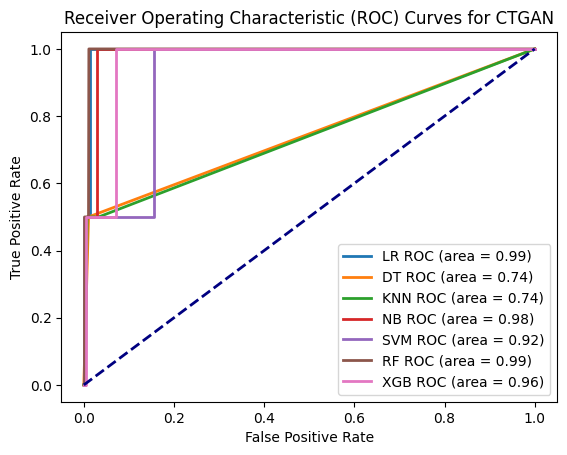

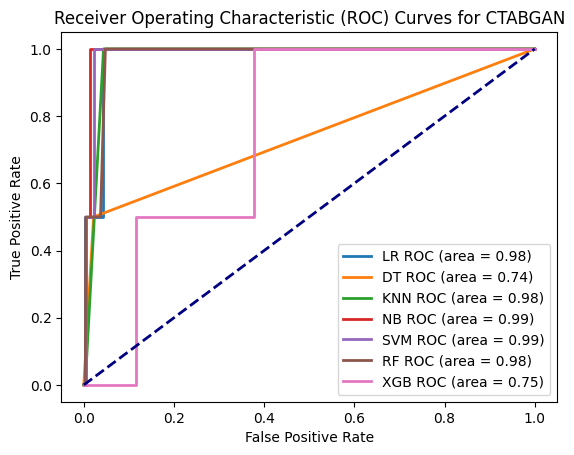

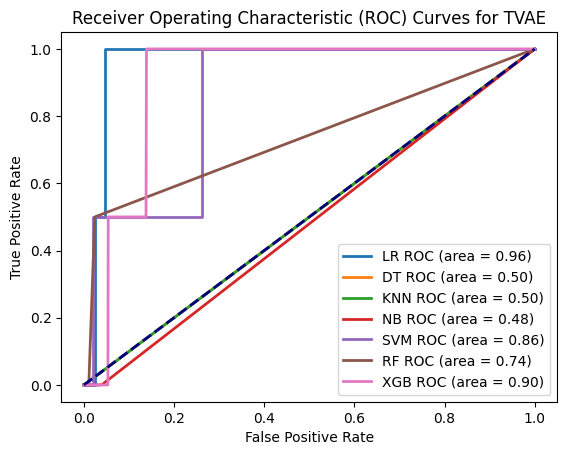

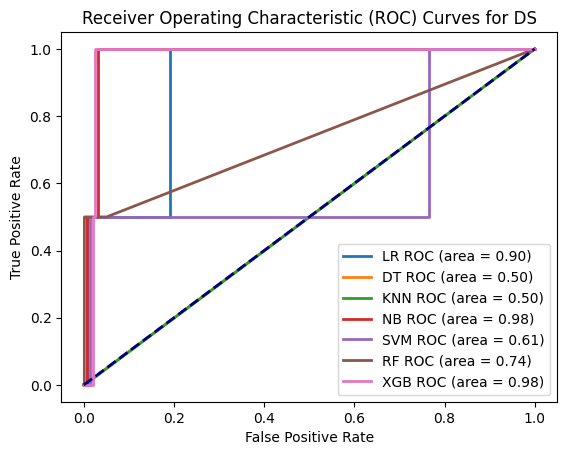

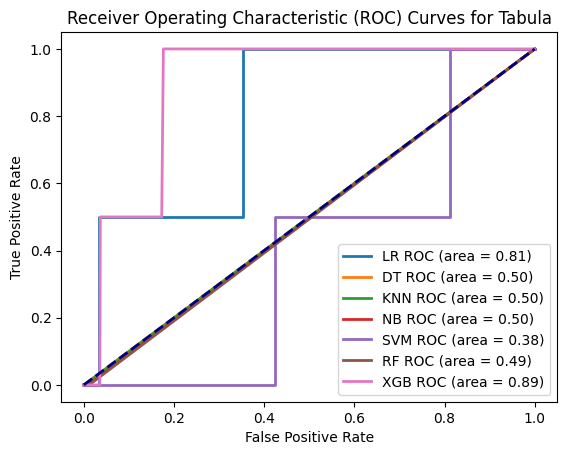

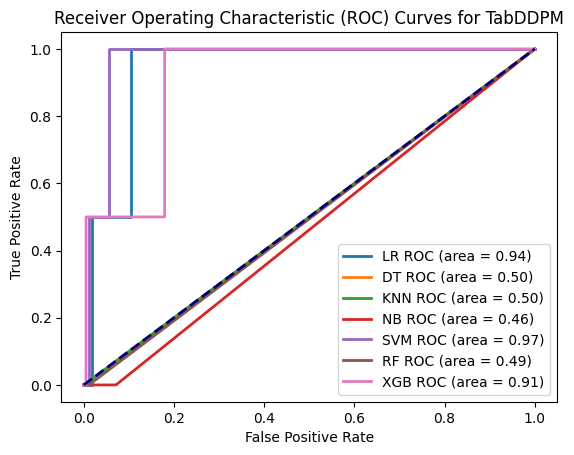

In [51]:
# Plot of ROC Curves for different samples
# Labels are models

for sample in samples.keys():
    for name, model in models.items():
        roc_auc = globals()[f'{sample}_{name}_auc']
        plt.plot(globals()[f'{sample}_{name}_fpr'], globals()[f'{sample}_{name}_tpr'], lw=2, label=f'{name} ROC (area = {roc_auc:.2f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curves for {sample}')
    plt.legend(loc="lower right")
    plt.show()

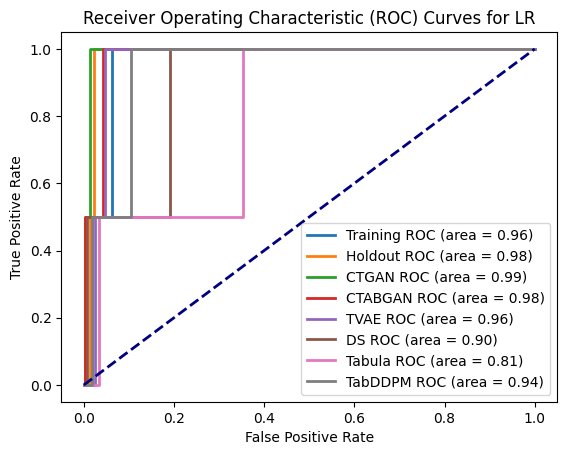

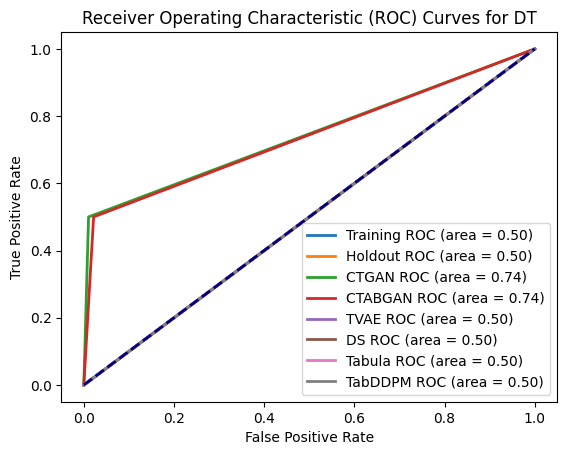

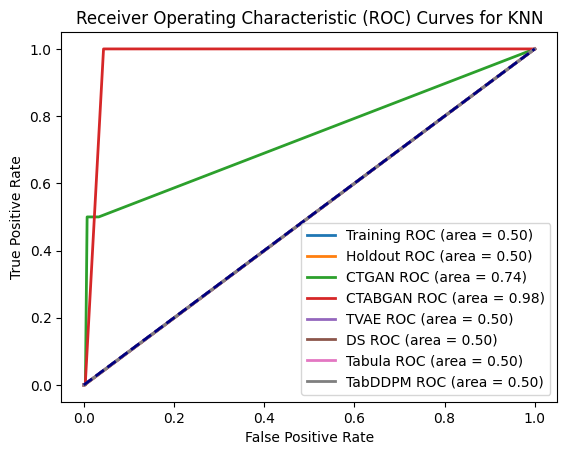

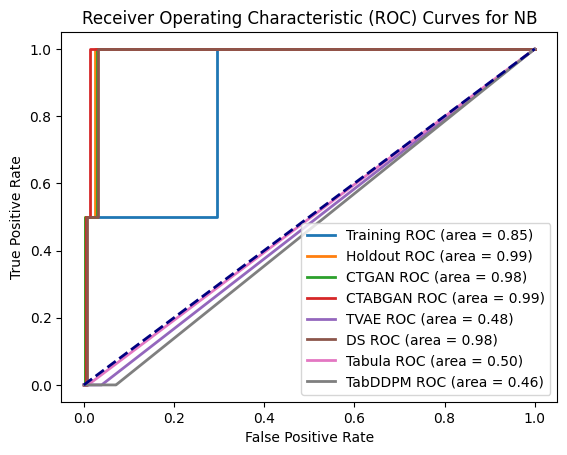

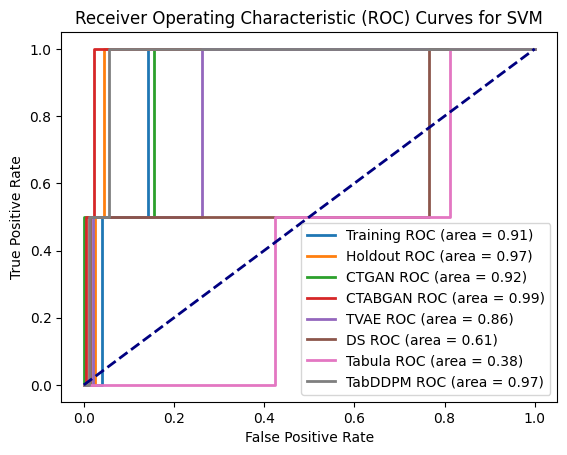

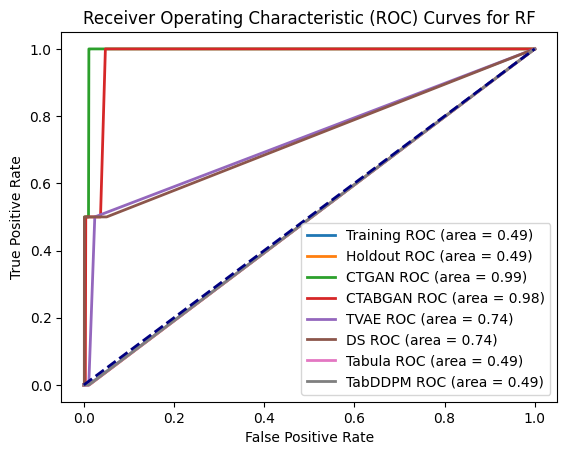

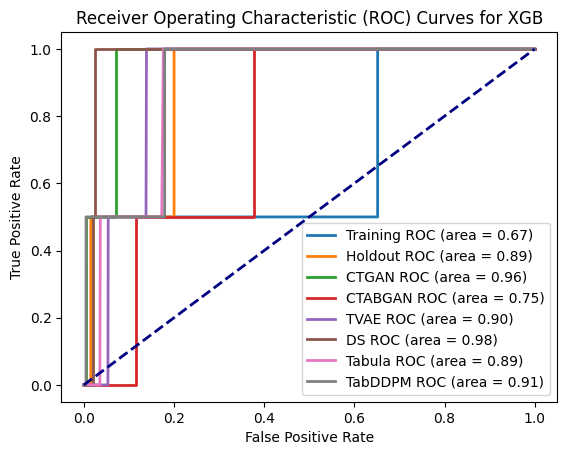

In [52]:
# Plot of ROC Curves for different models
# Labels are samples

for name, model in models.items():
    for sample in samples.keys():
        roc_auc = globals()[f'{sample}_{name}_auc']
        plt.plot(globals()[f'{sample}_{name}_fpr'], globals()[f'{sample}_{name}_tpr'], lw=2, label=f'{sample} ROC (area = {roc_auc:.2f})')
        
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curves for {name}')
    plt.legend(loc="lower right")
    plt.show()

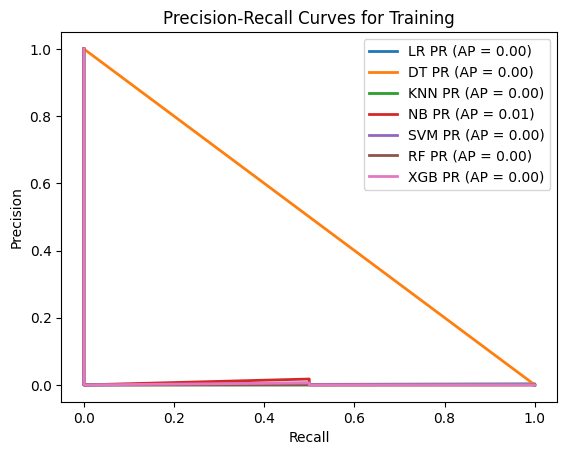

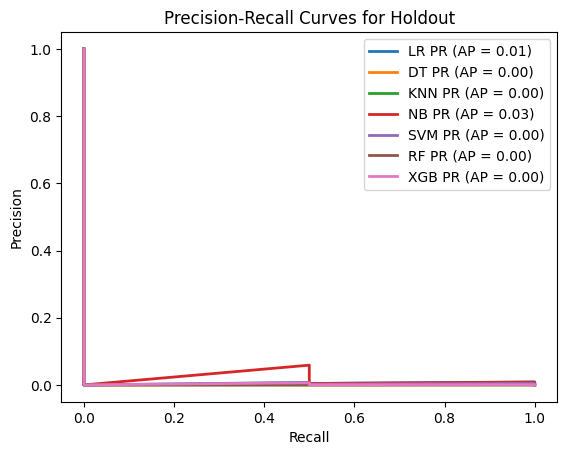

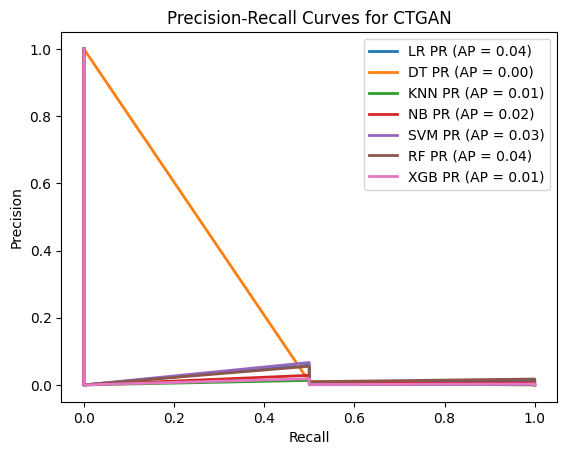

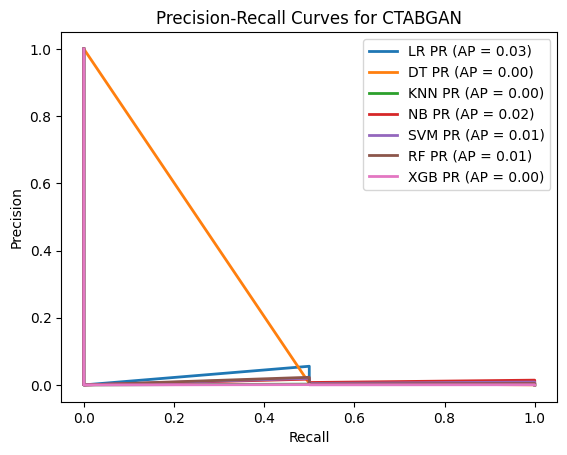

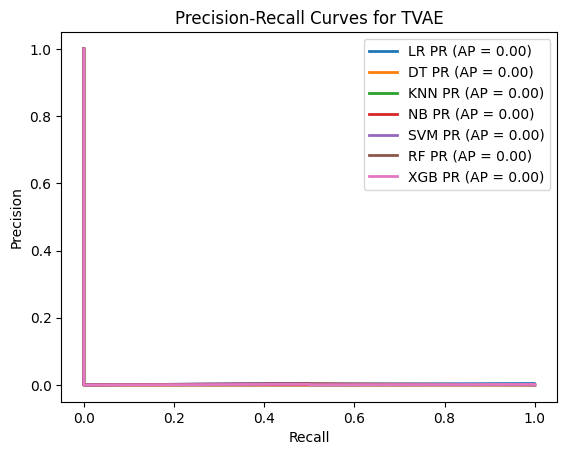

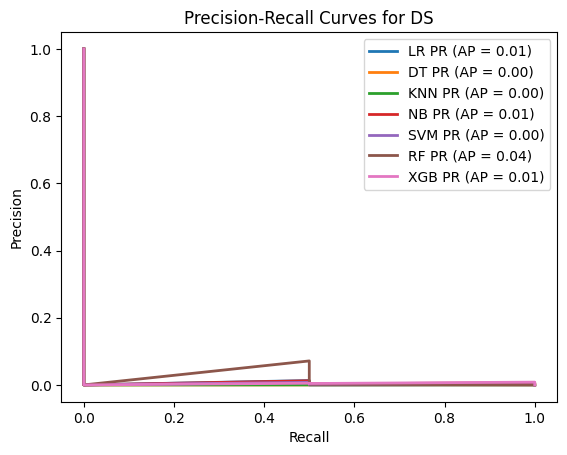

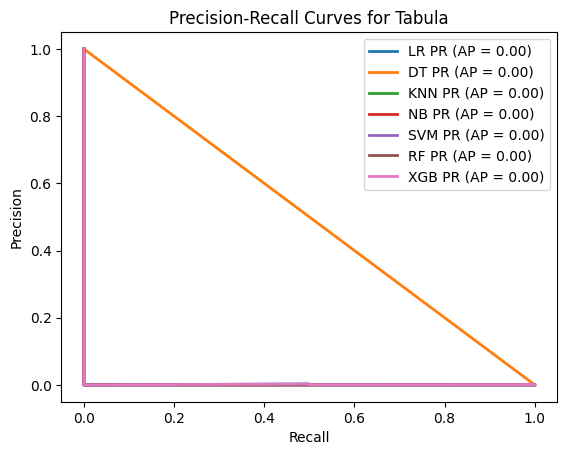

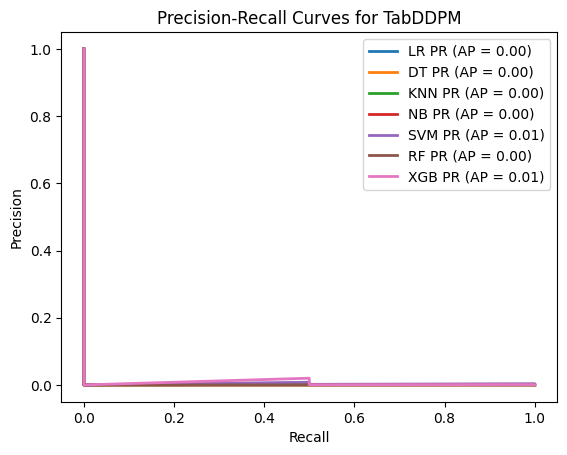

In [53]:
# Plot of Precision-Recall Curves for different samples
# Labels are models

for sample in samples.keys():
    for name, model in models.items():
        ap = globals()[f'{sample}_{name}_ap']
        plt.plot(globals()[f'{sample}_{name}_recall'], globals()[f'{sample}_{name}_precision'], lw=2, label=f'{name} PR (AP = {ap:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {sample}')
    plt.legend(loc="upper right")
    plt.show()

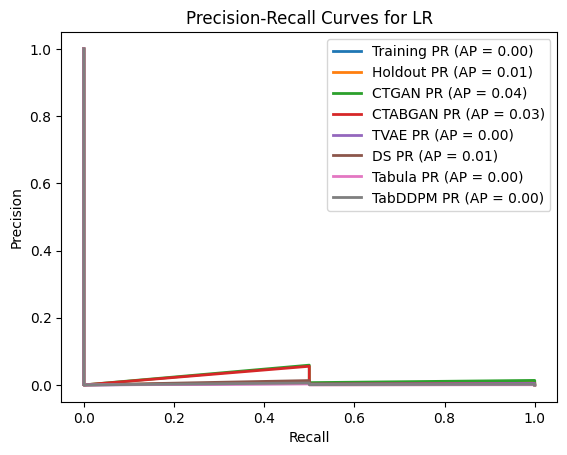

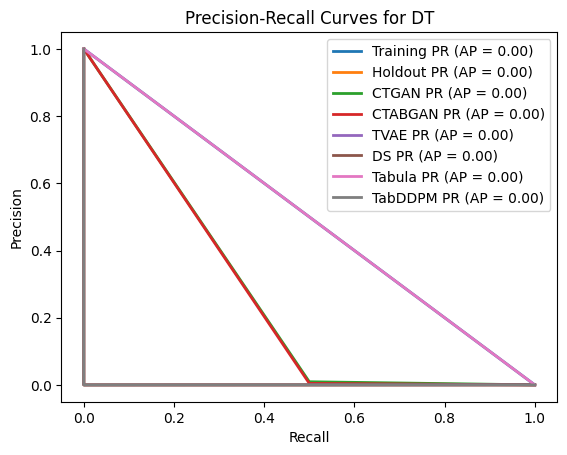

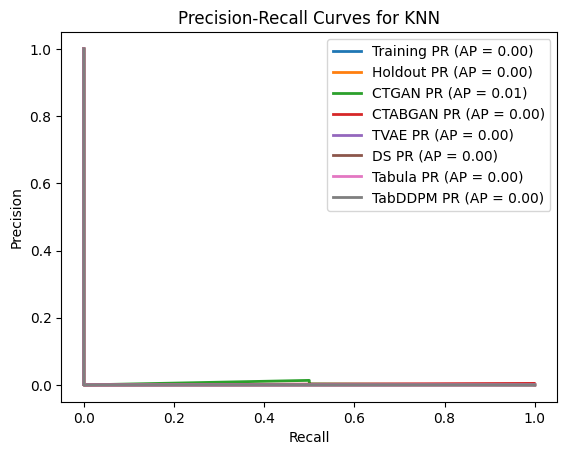

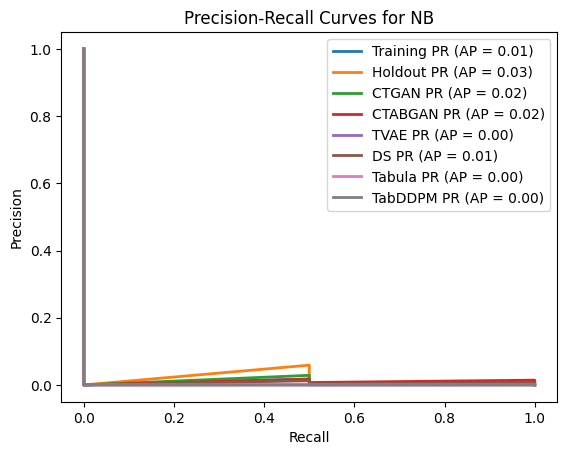

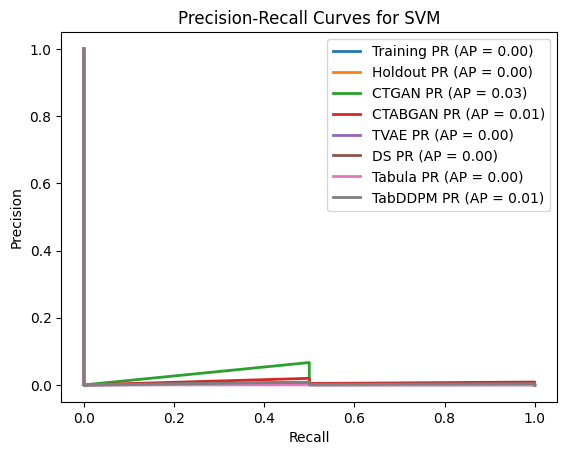

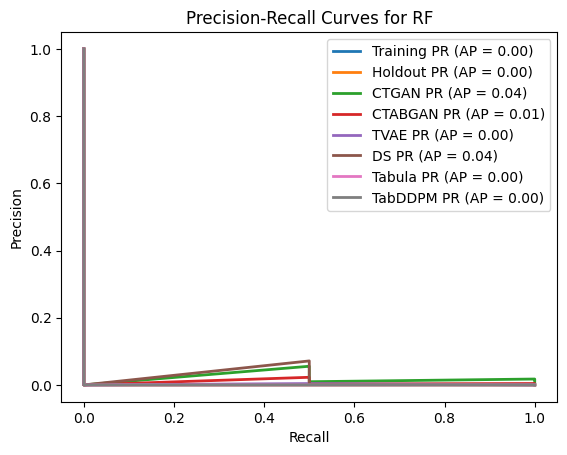

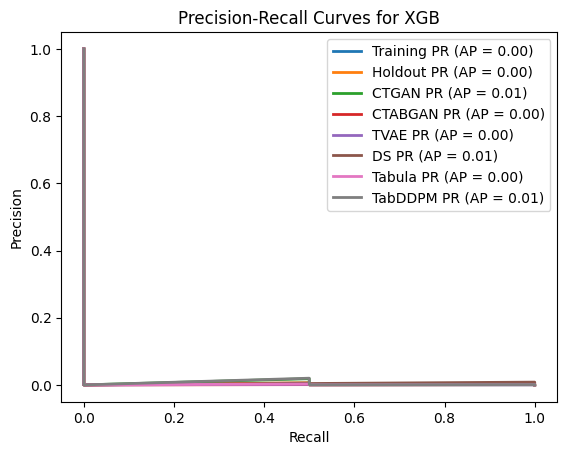

In [54]:
# Plot of Precision-Recall Curves for different models
# Labels are samples

for name, model in models.items():
    for sample in samples.keys():
        ap = globals()[f'{sample}_{name}_ap']
        plt.plot(globals()[f'{sample}_{name}_recall'], globals()[f'{sample}_{name}_precision'], lw=2, label=f'{sample} PR (AP = {ap:.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curves for {name}')
    plt.legend(loc="upper right")
    plt.show()